In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import stats
import pandas as pd
from scipy.linalg import eigh

In [2]:
# Load the data
def load_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Skip comment and description lines
            if line.startswith('%') or line.strip() == '' or 'X Height' in line:
                continue
            parts = line.split()
            if len(parts) == 2:
                try:
                    k = float(parts[0])
                    freq = float(parts[1])
                    data.append((k, freq))
                except ValueError:
                    continue
    return np.array(data)

In [3]:
def monolayer_hamiltonian(k, gamma_0, omega_0):
    """
    Constructs the monolayer Hamiltonian matrix for a given k value.

    Parameters:
    k : float - parameter k that parameterizes the irreducible Brillouin zone
    gamma_0 : float - free parameter to be optimized
    omega_0 : float - central frequency

    Returns:
    2x2 Hamiltonian matrix
    """
    # Calculate alpha and beta as functions of k
    if 0 <= k <= 1:
        alpha = 2/3 * k
        beta = 1/3 * k
    elif 1 <= k <= 2:
        alpha = 1/6 * (5 - k)
        beta = 1/6 * (k + 1)
    elif 2 <= k <= 3:
        alpha = 1/2 * (3 - k)
        beta = 1/2 * (3 - k)
    else:
        raise ValueError("k value out of range [0, 3]")

    # Calculate kx and ky
    k0 = 4 * np.pi / (3 * 15.0)
    kx = alpha * k0 * np.sqrt(3) / 2
    ky = k0 * (beta - alpha / 2)

    # Calculate f(k)
    f_k = np.exp(1j * ky * 15.0) + 2 * np.exp(-1j * ky * 15.0 / 2) * np.cos(kx * 15.0 * np.sqrt(3) / 2)

    # Construct the Hamiltonian matrix
    H = np.array([
        [omega_0, -gamma_0 * f_k],
        [-gamma_0 * np.conj(f_k), omega_0]
    ])

    return H

In [4]:
def calculate_eigenvalues(k, gamma_0, omega_0):
    """
    Calculates eigenvalues of the Hamiltonian for a given k value.

    Parameters:
    k : float - parameter k
    gamma_0 : float - free parameter
    omega_0 : float - central frequency

    Returns:
    Array of eigenvalues (frequencies)
    """
    H = monolayer_hamiltonian(k, gamma_0, omega_0)
    eigenvalues, _ = eigh(H)
    return np.real(eigenvalues)  # Ensure eigenvalues are real

In [5]:
# Define the cost function for optimization
def cost_function(params, k_values, measured_freq, num_bands=2):
    """
    Cost function to minimize: root-mean-square deviation between
    calculated and measured frequencies.

    Parameters:
    params : array-like - [gamma_0, omega_0]
    k_values : array-like - k parameter values
    measured_freq : array-like - measured frequencies
    num_bands : int - number of bands

    Returns:
    float - RMSD
    """
    gamma_0, omega_0 = params

    # Reshape measured frequencies to separate bands
    measured_reshaped = measured_freq.reshape(-1, num_bands)

    # Calculate model frequencies
    calculated_freq = np.array([calculate_eigenvalues(k, gamma_0, omega_0) for k in k_values])

    # Sort frequencies to ensure proper comparison
    calculated_freq.sort(axis=1)
    measured_reshaped.sort(axis=1)

    # Calculate RMSD
    diff = calculated_freq - measured_reshaped
    rmsd = np.sqrt(np.mean(diff**2))

    return rmsd

In [6]:
# Main function to fit data and generate output
def fit_hamiltonian(data_path, output_path):
    # Load data
    data = load_data(data_path)

    # Process data to get unique k values and corresponding frequencies
    unique_k = np.unique(data[:, 0])
    freq_matrix = np.zeros((len(unique_k), 2))

    for i, k in enumerate(unique_k):
        freqs = data[data[:, 0] == k, 1]
        freq_matrix[i, :len(freqs)] = freqs[:2]  # Taking first two frequencies

    # Initial guess for parameters [gamma_0, omega_0]
    # omega_0 is approximately the average of all frequencies
    initial_omega_0 = np.mean(freq_matrix)
    initial_params = [0.1, initial_omega_0]  # Initial guess for gamma_0 and omega_0

    # Optimize parameters
    result = minimize(
        cost_function,
        initial_params,
        args=(unique_k, freq_matrix, 2),
        method='Nelder-Mead'
    )

    gamma_0_opt, omega_0_opt = result.x
    print(f"Optimal parameters: gamma_0 = {gamma_0_opt}, omega_0 = {omega_0_opt}")
    print(f"Final RMSD: {result.fun}")

    # Generate fitted data for a fine k grid
    k_fine = np.linspace(np.min(unique_k), np.max(unique_k), 100)
    fitted_freq = np.array([calculate_eigenvalues(k, gamma_0_opt, omega_0_opt) for k in k_fine])

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], color = 'k', label='COMSOL Data')
    plt.plot(k_fine, fitted_freq[:, 0], 'r-', label='Fitted Bands')
    plt.plot(k_fine, fitted_freq[:, 1], 'r-')
    plt.xlabel('k Parameter')
    plt.ylabel('Frequency (GHz)')
    plt.title('Monolayer Graphene Hamiltonian Fitting')
    plt.legend()
    plt.grid(True)

    # Save fitted data to output file
    with open(output_file, 'w') as f:
        f.write("% Fitted data for Monolayer Graphene Hamiltonian\n")
        f.write(f"% Parameters: gamma_0 = {gamma_0_opt:.6f}, omega_0 = {omega_0_opt:.6f}\n")
        f.write(f"% RMSD = {result.fun:.8f}\n")
        f.write("% k Lower_Band Upper_Band\n")

        # Save all k_fine values and corresponding eigenvalues
        for i, k in enumerate(k_fine):
            f.write(f"{k:.6f} {fitted_freq[i, 0]:.6f} {fitted_freq[i, 1]:.6f}\n")

    return gamma_0_opt, omega_0_opt, k_fine, fitted_freq

Optimal parameters: gamma_0 = 0.1696080173789549, omega_0 = 3.9649625974569815
Final RMSD: 0.0007773148362624708


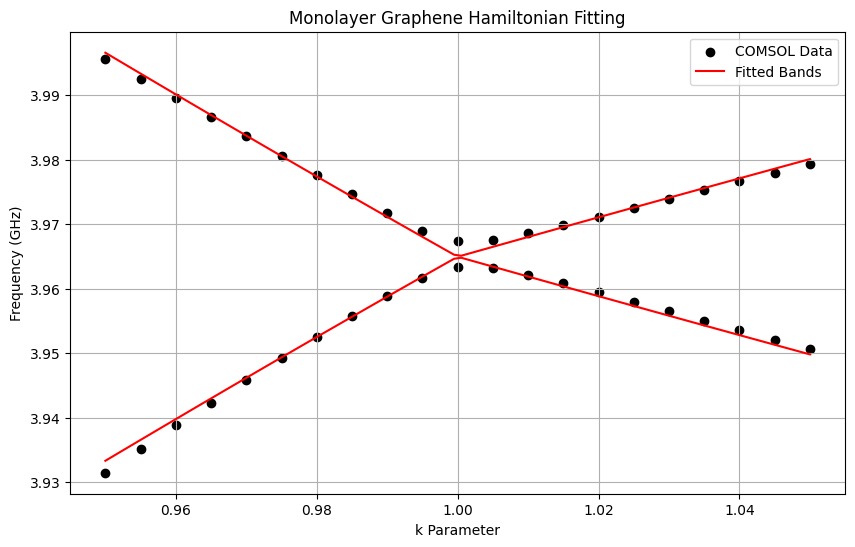

In [12]:
output_file = "Monolayer_fitted_data.txt"
gamma_0_opt, omega_0_opt, k_fine, fitted_freq = fit_hamiltonian('MonolayerNearDirac.txt', output_file)